In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = '../data/Screwdriving Model Experiments'
observation_file = 'observation_data.csv'
sensor_file = 'sensor_data.csv'
merged_file = 'merged_data.csv'
subdirs = os.listdir(data_dir)
files = list(map(lambda sd: os.path.join(data_dir, sd, observation_file), subdirs))
# files

In [3]:
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# df.head()

In [4]:
df.isna().sum()

time     0
X       66
Y       66
Z       66
dtype: int64

In [5]:
# df.describe()

3.813287


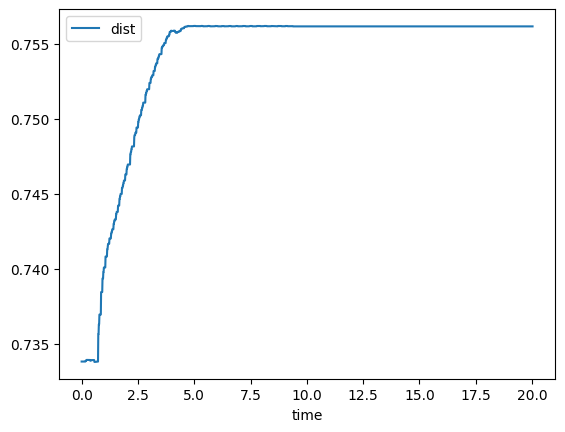

In [6]:

for subdir in subdirs[:1]:
    # input('wait for input...')

    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    obs_df['ref_time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    sen_df['time'] = pd.to_datetime(sen_df['time'])
    obs_df['ref_time'] = (obs_df['ref_time'] - obs_df['ref_time'].min()).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)

    tp_idx = sen_df[sen_df['dist'] >= 0.999 * sen_df['dist'].max()].index.min()

    print(sen_df.iloc[tp_idx]['time'])

    sen_df.plot(x='time', y=['dist'], kind='line')
    plt.show()

In [7]:
offset = -0.010  # seconds (sensor is this much time ahead of the camera, minus means behind; manually verified with the image timestamp)

for subdir in subdirs:
    # input('wait for input...')

    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    
    obs_df['time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    obs_df['time'] = (obs_df['time'] - obs_df['time'].min()).dt.total_seconds()
    
    sen_df['time'] = pd.to_datetime(sen_df['time'])    
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] + offset)

    observation_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(observation_file))
    sensor_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(sensor_file))
    obs_df.to_csv(observation_path_out, index=False)
    sen_df.to_csv(sensor_path_out, index=False)

    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)
    tp_idx = sen_df[sen_df['dist'] >= 0.999 * sen_df['dist'].max()].index.min()
    trim_time = sen_df['time'][tp_idx]
    
    tolerance = np.abs(offset)
    merged_df = pd.merge_asof(obs_df, sen_df.drop(columns=['X', 'Y', 'Z']), on='time', tolerance=tolerance, direction='nearest')
    merged_df = merged_df[merged_df['time'] >= trim_time]
    merged_df.reset_index(drop=True, inplace=True)
    merged_path_out = os.path.join(data_dir, subdir, merged_file)
    merged_df.to_csv(merged_path_out, index=False)
